# WHETGEO-1D ex_03
## Infiltration excess process


    - Authors: Niccolò Tubini and Riccardo Rigon
    - Licence: this work is licensed under a Creative Commons Attribution-NonCommercial 4.0 International License
_____ 

In this tutorial you will learn how to set up WHETGEO-1D for solving the Richardson-Richards equation (R2) to simulate the water infiltration in a two-layered soil. Unlike the previous examples, now we drive the simulation with a rainfall time series and account for water ponding at the soil surface. 


## Contents
    
* [Tutorial example and objectives](#Description)
    
* [Pre-processing](#pre-processing)
    - [soil hydraulic parameters](#soil_parameters)
    - [initial condition](#initial_condition)
    - [Define the computational grid](#computational_grid)
    - [Create the computational grid](#create_the_computational_grid)
    
* [Set up the .sim file](#setup)
    
* [Run the simulation](#run)
    
* [Post-processing](#post_processing)

Finora abbiamo visto due condizioni al contorno; in questo esercizio vediamo il runoff superficiale per eccesso precipitazione rispetto a quello che si infiltra nel suolo

In precedenza abbiamo visto Dirichlet che controllava infiltrazione; nell'esempio 02 avevamo precipitazione con intensità tale che acqua continuava a infiltrarsi.

Fintanto che intensità di pioggia > flusso di infiltrazione: parte di questa si accumula in superfice. Meccanismo Dunniano (? o hortoniano non mi ricordo)

## Tutorial example and objectives <a class="anchor" id="Description"></a>

This example presents two synthetic simulations about the Infiltration excess process.

The definition of the surface boundary condition is a nontrivial task since it is a system-dependent boundary condition. The infiltration rate through the soil surface depends on precipitation, rainfall intensity $J$, and on the moisture condition of the soil. Because of this, the surface boundary condition may change from the Dirichlet type - prescribed water suction - to the Neumann type - prescribed flux - and vice-versa. The works by Horton (1933) and Dunne and Black (1970) establish the conceptual framework to explain the runoff generation. The infiltration excess or Horton runoff occurs when the rainfall intensity is larger than infiltration capacity of the soil:
$$J > \big|-K(\psi)\dfrac{\partial \psi}{\partial z} - K(\psi)\big|\Big|_{\eta=0} $$
Infiltration excess is most commonly observed with short-duration, intense rainfall.

In this notebook we present two test cases simulating the infiltration excess process.

<figure>
    <img src="Figures/ex03.png" width="800" height="800/1.618">
    <figcaption>Fig.1 - WHETGEO-1D ex03. </figcaption>
<figure>
    
    

In this numerical experiment we consider a homogeneous soil of 3 [m] depth. Soil hydraulic properties are described with the Van Genuchten’s model 

|$\theta_r$ [-]|$\theta_s$ [-]|$\alpha$ [m$^{-1}$] |$n$ [-]|$K_s$ [m s$^{-1}$]   |  
|--------------|--------------|--------------------|-------|---------------------|
|$0.089$       |$0.43$        |$1.0$               |$1.23$ |$1.9447 \times 10^{-7}$|

The surface boundary condition is a synthetic
rainfall, lasting $15$ [min] with constant intensity of $0.028$ [mm s$^{-1}$].

Here we consider two different intial conditions. In the first case, the initial condition is assumed to be hydrostatic with $\psi=0$ [m] at the bottom. We refer to this simulation as 'wet'. In the second case, the initial condition is assumed to be hydrostatic with $\psi=-100$ [m] at the bottom. We refer to this simulation as 'dry'.

This example aims to show:
- the advance of the wetting front both in terms of water pressure and water content
- the ponding of water at the soil surface
- the fluxes through the soil surface and the bottom.


Sarà possibile data una precipitazione, calcolare quanta acqua si accumula in superficie dando in imput la pioggia: generalmente in altri codici l'accoppiamento viene fatto in modo che si passa alla condizione di contorno più favorevole. in questo caso specifichiamo l'intensità di pioggia e il codice in automatico dice se c'è deflusso; 

abbiamo un unico layer

## Pre-processing  <a class="anchor" id="pre-processing"></a>

To numerically solve the R2 equation it is necessary to discretize the domain, assign the soil parameters, assign the initial condition for the water pressure, and prescribe the type and the values for the boundary conditions.

All these information are contained in the folder `/data` of your OMS project. Specifically
- `data/Grid_input` contains the .csv file used to define the computational grid. To define a compuational grid we need of three files:
    - one defining the computational grid;
    - one defining the initial condition;
    - one containing the soil parameters.
    These files are elaborated by a Jupyter notebook in order to set up the computational grid. 
- `data/Grid_NetCDF` collects the netCDF files (.nc) containing all the data of the computational grid, i.e. geometrical quantities, soil parameters, and the initial condition. 
- `/data/Timeseries` contains the time series for the boundary conditions and a time series used to select the time step we want to use. All these time series are .csv files OMS compliant. To know how to prepare such files please have a look at the notebook `00_OMS_Timeseries.ipynb`.

### Soil parameters <a class="anchor" id="soil_parameters"></a>

The soil hydraulic properties are define by the Van Genucthen model.

For instance, the parameters for the Van Genuchten model are defined in the file `data/Grid_input/Richards_VG.csv`. These values are those presented in Bonan et al. 2019.
The first line defines the column header, and # is used to add some comments in the file.

Each soil is identified by a number, 1 stands for sand, 2 for Loamy-sand, and so on. These numbers are used later to define the stratigraphy of the soil. 

Of course you can create your own file by copying the header and fill it with your values. 

### Initial condition <a class="anchor" id="initial_condition"></a>

The initial condition is defined starting from values prescribed in some specific points (depths) of the soil profile. These values can be the result of some field survey or, when not available, you may choose them.

For each control volume we must assign an initial condition, and this is obtained by interpolating the values.

### Define the computational grid <a class="anchor" id="computational_grid"></a>

The file is `/data/Grid_input/ex03_grid.csv`. This files contains five columns

| Type    | eta   | K      | equationStateID   | parameterID |
|---------|-------|--------|-------------------|-------------|

where:
- **Type** this column contains L or M. L is used to specify the surface and bottom of the soil profile as well as the interface between two different soil layers. M is used to specify a measurament point used to identify the position of experimental data points for inverse modelling pourposes.
- **eta** is the vertical coordinate positive upward with 0 set at the soil surface
- **K** is the number of the control volumes used to discretize each soil layer
- **equationStateID** it is an integer defining which equation state we want to use. This number corresponds to an index of vector that we will define in the .sim file. For now it is 0.
- **parameterID** it is an integer defining the set of soil parameters for each layer. This numeber corresponds to an index of the vector containing all the values of a specific parameter.


Let's start with defining the stratigaphy of the soil profile. In our example we have a single-layered profile of $3$ [m]. Let us assume we want to discretize the domain with 600 control volumes, thus with a spatial resolution of $0.005$ [m]. We can edit the file `/data/Grid_input/ex03_grid.csv` as

| Type    | eta   | K      | 
|  :---:  | :---: | :---:  | 
|L        | 0     | 600    |
|L        | -3    | nan    |

Then we can complete `/data/Grid_input/ex03_grid.csv` adding values for the remaining columns. Here we simulate but the water depth and the R2 equation, therefore **equationStateID** 0 identifies water depth and 1 the R2 equation. As soil type we chose silty clay loam, **parameterID** is 7.

| Type    | eta   | K      | equationStateID   | parameterID |
|  :---:  | :---: | :---:  | :---:             | :---:       |
|L        | 0     | 600    | 1                 | 7           |
|L        | -3    | nan    | nan               | nan         |

### Create the computational grid<a class="anchor" id="create_the_computational_grid"></a>

To create the computational grid we can use the notebook `Jupyter_Notebook/WHETGEO1D_RichardsCoupled_Computational_grid.ipynb`.
In the following we report the input required to create the grid.


#### Define input:
**grid_input_file_name**: name of the grid input file (.csv) with the local file path 
   
> `/data/Grid_input/name.csv`

**ic_input_file_name**: name of the initial condition input file (.csv) with the local file path 
> `/data/Grid_input/name.csv`

**parameter_input_file_name**: name of the parameter input file (.csv) with the local file path 
>`/data/Grid_input/name.csv`

**dictionary_input_file_name**: name of the file (.csv) containing the dictionary for parameters name 
>`/data/Grid_input/name.csv`

**grid_type**: string defining how to discretize the 1D domain. You can choose among:
> `classical`


**dz_min**: thickness of the first layer (for `exponential` and `mixed`)

**dz_max**: larger thickness of the grid (for `mixed`)

**b**: growth rate (for `exponential` and `mixed`)

**psi_interp_model**: string defining the type of the 1D interpolation function used to define the initial condition for water suction 
> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d 

**T_interp_model**: string defining the type of the 1D interpolation function used to define the initial condition for temperature
>https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d 

**water_ponding_0**: double [m] defining the water suction at soil surface. If it is larger than $0$ means that there is water ponding.

**T_water_ponding_0**: double [K] defining the temperature at soil surface. 


**output_file_name**: name of the output file (.nc) with the local file path
>`/data/Grid_NetCDF/name.nc`

**output_title**: string containing a title for the output, it is saved within the file

**output_summary**: string containing a description for the output, it is saved within the file (global metadata)

**output_date**: string containing the date of file creation, optionally

**output_institution**: string containing the name of whom created the file, optionally



In [3]:
import os
import pandas as pd

from geoframepy.whetgeo1d import grid_creator
from geoframepy.whetgeo1d import grid_to_netcdf

import warnings
warnings.filterwarnings('ignore')


project_path = os.path.dirname(os.getcwd())


grid_input_file_name = project_path + "/data/Grid_input/ex03_grid.csv"

ic_input_file_name = project_path + "/data/Grid_input/ex03_ic_wet.csv"

parameter_input_file_name = project_path + "/data/Grid_input/Richards_VG.csv"

dictionary_input_file_name = project_path + "/data/Grid_input/dictionary.csv"

grid_type = 'classical'

dz_min = -9999 # not required for grid_type = 'classical'

dz_max = -9999 # not required for grid_type = 'classical'

b = -9999      # not required for grid_type = 'classical'

psi_interp_model = "linear"

T_interp_model = "linear"

water_ponding_0 = -3.0

T_water_ponding_0 = 273.15

output_file_name =  project_path + "/data/Grid_NetCDF/ex03_grid_wet.nc"

output_title = '''Computational grid for ex03 wet initial condition.
                  '''
output_summary = '''

'''

output_date = ''

output_institution = 'GEOframe'



In [16]:
data_grid = pd.read_csv(grid_input_file_name)
# print('Grid')
# print(data_grid)
# print()

data_ic = pd.read_csv(ic_input_file_name)
# print('IC')
# print(data_ic)
# print()

data_parameter = pd.read_csv(parameter_input_file_name, comment='#')
# print('Parameter')
# print(data_parameter)
# print()

data_dictionary = pd.read_csv(dictionary_input_file_name)

[KMAX, eta, eta_dual, space_delta, z, z_dual, control_volume] = grid_creator.grid1D(data_grid, dz_min, b, dz_max, grid_type, shallow_water=True)

[psi_0, T_0] = grid_creator.set_initial_condition(data_ic, eta, psi_interp_model, T_interp_model, water_ponding_0=water_ponding_0, T_water_ponding_0=T_water_ponding_0, shallow_water=True)

control_volume_index = grid_creator.calibration_point_index(data_grid, eta)

[equation_state_ID, parameter_ID, theta_s, theta_r, par_1, par_2, par_3, par_4,
par_5, alpha_ss, beta_ss, ks] = grid_creator.set_parameters_richards(data_grid, data_parameter, data_dictionary, KMAX, eta)

grid_to_netcdf.write_grid_netCDF_richards(eta, eta_dual, z, z_dual, space_delta, control_volume, control_volume_index, psi_0, T_0, equation_state_ID, parameter_ID, KMAX,
                  theta_s, theta_r, par_1, par_2, par_3, par_4, par_5, alpha_ss, beta_ss, ks,
                  output_file_name, output_title, output_institution, output_summary, output_date, grid_input_file_name, parameter_input_file_name)



***SUCCESS writing!  C:\Users\Niccolo\OMS\OMS_Project_WHETGEO1D_SummerSchool2021/data/Grid_NetCDF/ex03_grid_wet.nc


## Setup the ex03.sim file <a class="anchor" id="setup"></a>

To setup the `ex_03.sim` you can:

- open it with a text editor

- use the text editor of Jupyter Notebook

- edit and save the file directly within this notebook. In this case you load the file with the magic `%load filename`, edit the file, save the file by calling `%%writefile filename` at the beginning of the cell containing the your file.

In [12]:
# %load C:\Users\Niccolo\OMS\OMS_Project_WHETGEO1D_Idrologia_ay_21_22\simulation\WHETGEO1D_ex03_wet.sim
/*
 * WHETGEO-1D ex03
 * 
 * Author: Niccolo` Tubini and Riccardo Rigon
 */
import static oms3.SimBuilder.instance as OMS3
import static oms3.SimBuilder.*
def home = oms_prj



def richardsGridFileName = "$oms_prj//data/Grid_NetCDF/ex03_grid_wet.nc"

def typeClosureEquation = "{Water Depth,Van Genuchten}"

def typeEquationState = "{Water Depth,Van Genuchten}"

def typeUHCModel = "{null,Mualem Van Genuchten}"

def typeUHCTemperatureModel = "notemperature"

def interfaceHydraulicConductivityModel = "max"

def topBCType = "Top Coupled"

def bottomBCType = "Bottom free drainage"

def maxPonding = 0.0

def stationID = "0"

def startDate= "2020-01-01 00:00"

def endDate= "2020-01-01 23:55"

def tTimestep = 5

def topBCFileName = "$oms_prj//data/Timeseries/ex03_rainfall.csv"

def bottomBCFileName = "$oms_prj//data/Timeseries/ex03_dirichlet_wet.csv"

def saveDatesFileName = "$oms_prj//data/Timeseries/ex03_save_dates.csv"

def outputFileName = "$oms_prj//output/ex03_wet.nc"


def writeFrequency = 10000


solver = OMS3.sim(name: "Integrate PDE", {

resource "$oms_prj/dist"

	model(while : "reader_data_topBC.doProcess"  ){

		components {
			
			// reads of the grid.nc file
			"readNetCDF" "it.geoframe.blogpsot.netcdf.monodimensionalproblemtimedependent.ReadNetCDFRichardsGrid1D"
			
			// solve Richards' equation
			"solver" "it.geoframe.blogspot.whetgeo1d.richardssolver.RichardsSolver1DMain"
			
			// time-series reader
			"reader_data_topBC"         "org.jgrasstools.gears.io.timedependent.OmsTimeSeriesIteratorReader"
			"reader_data_bottomBC"      "org.jgrasstools.gears.io.timedependent.OmsTimeSeriesIteratorReader"
			"reader_data_save_dates"    "org.jgrasstools.gears.io.timedependent.OmsTimeSeriesIteratorReader"
			
			// this component stores solver's output during the simulation
			"buffer" "it.geoframe.blogspot.buffer.buffertowriter.RichardsBuffer1D"
			
			// output writer in a NetCDF format
			"writeNetCDF" "it.geoframe.blogpsot.netcdf.monodimensionalproblemtimedependent.WriteNetCDFRichards1DDouble"
		
		}
		
		parameter {

			"readNetCDF.richardsGridFilename" "${richardsGridFileName}"


			"solver.typeClosureEquation" "${typeClosureEquation}"
			

			"solver.typeEquationState" "${typeEquationState}"


			"solver.typeUHCModel" "${typeUHCModel}"


			"solver.typeUHCTemperatureModel" "${typeUHCTemperatureModel}"

            
			"solver.interfaceHydraulicConductivityModel" "${interfaceHydraulicConductivityModel}"
						

			"solver.topBCType"  "${topBCType}"

            
			"solver.bottomBCType"  "${bottomBCType}"
			
			"solver.maxPonding" "${maxPonding}"

            
			"solver.stationID"  "${stationID}"
			

			"solver.newtonTolerance" "0.00000000001"


			"solver.nestedNewton" "1"


			"solver.tTimeStep" tTimestep*60


			"solver.timeDelta" tTimestep*60

			"reader_data_topBC.file"             "${topBCFileName}"
			"reader_data_topBC.idfield"          "ID"  
			"reader_data_topBC.tStart"           "${startDate}"
			"reader_data_topBC.tEnd"             "${endDate}"
			"reader_data_topBC.tTimestep"        "${tTimestep}"
			"reader_data_topBC.fileNovalue"      "-9999"

			"reader_data_bottomBC.file"             "${bottomBCFileName}"
			"reader_data_bottomBC.idfield"          "ID"  
			"reader_data_bottomBC.tStart"           "${startDate}"
			"reader_data_bottomBC.tEnd"             "${endDate}"
			"reader_data_bottomBC.tTimestep"        "${tTimestep}"
			"reader_data_bottomBC.fileNovalue"      "-9999"
			
			"reader_data_save_dates.file"             "${saveDatesFileName}"
			"reader_data_save_dates.idfield"          "ID"  
			"reader_data_save_dates.tStart"           "${startDate}"
			"reader_data_save_dates.tEnd"             "${endDate}"
			"reader_data_save_dates.tTimestep"        "${tTimestep}"
			"reader_data_save_dates.fileNovalue"      "-9999"
			
			
			"buffer.writeFrequency"                   "${writeFrequency}"

			// folder path for the output files
			"writeNetCDF.fileName" "${outputFileName}"
			// here you can enter a string to describe your simulation
			"writeNetCDF.briefDescritpion"               "WHETGEO-1D ex03 wet initial condition."
			"writeNetCDF.writeFrequency"                 "${writeFrequency}"
			"writeNetCDF.timeUnits"                      "Minutes since 01/01/1970 00:00:00 UTC"
			"writeNetCDF.timeZone"                       "UTC"
			"writeNetCDF.fileSizeMax"                    "10000"
			"writeNetCDF.outVariables"                   "{darcyVelocity}"
			"writeNetCDF.pathGrid"		                 "${richardsGridFileName}"
			"writeNetCDF.pathTopBC"		                 "${topBCFileName}"
			"writeNetCDF.pathBottomBC"	                 "${bottomBCFileName}"
			"writeNetCDF.topBC"		                     "${topBCType}"
			"writeNetCDF.bottomBC"	                     "${bottomBCType}"
			"writeNetCDF.swrcModel"                      "${typeClosureEquation}"
			"writeNetCDF.soilHydraulicConductivityModel" "${typeUHCModel}"
			"writeNetCDF.interfaceConductivityModel"     "${interfaceHydraulicConductivityModel}"
			
		}

		connect{


			"readNetCDF.z"                      "solver.z"
			"readNetCDF.spaceDelta"             "solver.spaceDeltaZ"
			"readNetCDF.psiIC"                  "solver.psiIC"
			"readNetCDF.temperature"            "solver.temperature"
			"readNetCDF.controlVolume"          "solver.controlVolume"
			"readNetCDF.Ks"                     "solver.ks"
			"readNetCDF.thetaS"                 "solver.thetaS"
			"readNetCDF.thetaR"                 "solver.thetaR"
			"readNetCDF.par1SWRC"               "solver.par1SWRC"
			"readNetCDF.par2SWRC"               "solver.par2SWRC"
			"readNetCDF.par3SWRC"               "solver.par3SWRC"
			"readNetCDF.par4SWRC"               "solver.par4SWRC"
			"readNetCDF.par5SWRC"               "solver.par5SWRC"
			"readNetCDF.alphaSS"                "solver.alphaSpecificStorage"
			"readNetCDF.betaSS"                 "solver.betaSpecificStorage"
			"readNetCDF.equationStateID"        "solver.inEquationStateID"
			"readNetCDF.parameterID"            "solver.inParameterID"

			"reader_data_topBC.tCurrent"        "solver.inCurrentDate"
			"reader_data_topBC.outData"         "solver.inTopBC"
			"reader_data_bottomBC.outData"      "solver.inBottomBC"
			"reader_data_save_dates.outData"    "solver.inSaveDate"
			
			
			
			// input buffer
			"solver.inCurrentDate"        "buffer.inputDate"
			"solver.doProcessBuffer"      "buffer.doProcessBuffer"
			"solver.outputToBuffer"       "buffer.inputVariable"

			
			// input writeNetCDF
			"reader_data_topBC.doProcess"        "writeNetCDF.doProcess"
			
			"buffer.myVariable"                  "writeNetCDF.variables"
			
			"readNetCDF.eta"                     "writeNetCDF.spatialCoordinate"
			"readNetCDF.etaDual"                 "writeNetCDF.dualSpatialCoordinate"
			"readNetCDF.controlVolume"           "writeNetCDF.controlVolume"
			"readNetCDF.psiIC"                   "writeNetCDF.psiIC"
			"readNetCDF.temperature"             "writeNetCDF.temperature"
			
			
		}
	}

	}

)


**Here a brief explanation on how to specify the input of the simulation.**

Firts of all we have to specify the file containing the computational grid

```groovy
    def richardsGridFileName = "$oms_prj//data/Grid_NetCDF/ex03_grid_wet.nc"
```

This file contains all the data, geometrical quantities, soil parameters, and initial condition of the problem.


As said above the soil hydraulic properties are described by the van Genuchten model, so we specify
```groovy
def typeClosureEquation = "{Water Depth,Van Genuchten}"
def typeEquationState = "{Water Depth,Van Genuchten}"
def typeUHCModel = "{null,Mualem Van Genuchten}"
```
As regards the unsaturated hydraulic conductivity model, up to now we do not want to take into account the effect of soil temperature on the water viscosity thus we specify
```groovy
def typeUHCTemperatureModel = "notemperature"
```
Then it is necessary to prescribe how to evaluate the unsaturated hydraulic conductivity at the interface between two adjacent control volumes
```groovy
def interfaceHydraulicConductivityModel = "harmonic mean"
```

Now we move to the definition of the boundary conditions: one at the soil surface (_top_) and at the bottom of the soil column (_bottom_). The boundary condition control the time evolution of the system and their must be consistent with the problem one wants to solve. In this example we couple the R2 with the shallow water equation thus we have
```groovy
def topBCType = "Top Coupled"
```

Regarding the bottom boundary condition, we assume that water flows downward accordingly to the gravity force, the gradient of $\psi$ is 0. 
```groovy
def bottomBCType = "Bottom free drainage"
```

The input variable 
```groovy
def maxPonding = 0.0
```
defines the maximum ponding water at the soil surface [m]. 0 is the default value and means that ponding is not limited.

Then we need to specify the start date and end date [yyyy-mm-dd hh:mm] of the simulation 
```groovy
def startDate= "2020-01-01 00:00"
def endDate="2020-01-02 00:00"
```
and the time step [minutes] of the time series of the boundary conditions 
```groovy
def tTimestep = 5
```

The components that read the time series require as input the header of the column containg the values. This header can be found at line 5 of each `.csv` and this value must be equal for all the files containing the time series of the simulation
```groovy
def stationID = "0"
```

The files containing the time series for the _top_ and _bottom_ boundary condition are respectively
```groovy
def topBCFileName = "$oms_prj//data/Timeseries/ex03_rainfall.csv"
def bottomBCFileName = "$oms_prj//data/Timeseries/ex03_dirichlet_wet.csv"
```
To be noted that the in case of free drainage boundary condition we do not have to provide any value, but we must provide for the component responsible for reading the time series. 

Moreover, we provide another time series that specify for which date we want to save the output on the disk: 1 to save outputs, 0 otherwise
```groovy
def saveDatesFileName = "$oms_prj//data/Timeseries/ex03_save_dates.csv"
```

At last we can specify path of the output file. Usually output are save in the `output` folder of the project. If you prefer you can save it in a different folder the important thing is that the folder you specify exists
```groovy
def outputFileName = "$oms_prj//output/ex03_wet.nc"
```

## Post-processing  <a class="anchor" id="post_processing"></a>

Once you have run the simulation, you can find the output in the folder `output`. The file is a netCDF and it can be easily read with the [xarray](http://xarray.pydata.org/en/stable/). 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.style as style 
import matplotlib.colors as cl
import matplotlib.dates as mdates
import matplotlib
from geoframepy.timeseries import io_csv
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

style.available
style.use('seaborn-whitegrid')

nice_fonts = {
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.facecolor": "white",
        "axes.edgecolor": "0.8",
        "axes.linewidth": 0.6,
        "grid.linewidth":0.4,
        "text.usetex": True,
        "font.family": "serif",
        "axes.labelsize": 16,
        "font.size": 16,
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
}

my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ece7f2","#d0d1e6","#a6bddb","#74a9cf","#3690c0","#0570b0","#045a8d","#023858"])
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00']

plt.rcParams.update(nice_fonts)

**Read the output file**

In [7]:
ds = xr.open_dataset(project_path + '/output/ex03_wet_0000.nc')
ds

<xarray.Dataset>
Dimensions:        (depth: 601, dualDepth: 601, time: 288)
Coordinates:
  * depth          (depth) float64 -2.998 -2.993 -2.988 ... -0.0075 -0.0025 0.0
  * dualDepth      (dualDepth) float64 -3.0 -2.995 -2.99 ... -0.01 -0.005 0.0
  * time           (time) datetime64[ns] 2020-01-01 ... 2020-01-01T23:55:00
Data variables:
    psi            (time, depth) float64 ...
    psiIC          (depth) float64 ...
    T              (depth) float64 ...
    theta          (time, depth) float64 ...
    darcyVelocity  (time, dualDepth) float64 ...
    waterVolume    (time, depth) float64 ...
    error          (time) float64 ...
    topBC          (time) float64 ...
    bottomBC       (time) float64 ...
    runOff         (time) float64 ...
    controlVolume  (depth) float64 ...
Attributes:
    Description_of_the_problem:         WHETGEO-1D ex03 wet initial condition.
    Top_boundary_condition:             Top Coupled
    Bottom_boundary_condition:          Bottom free drainage
    path_top_boundary_condition:        C:\Users\Niccolo\OMS\OMS_Project_WHET...
    path_bottom_boundary_condition:     C:\Users\Niccolo\OMS\OMS_Project_WHET...
    path_grid:                          C:\Users\Niccolo\OMS\OMS_Project_WHET...
    time_delta:                          
    swrc_model:                         {Water Depth,Van Genuchten}
    soil_hydraulic_conductivity_model:  {null,Mualem Van Genuchten}
    interface_conductivity_model:       max

In [28]:
rain = io_csv.pandas_read_OMS_timeseries(project_path + '/data/Timeseries/ex03_rainfall.csv',datetime_index=True)
rain.head()

,0
Datetime,
2020-01-01 00:00:00,0.0
2020-01-01 00:05:00,0.0
2020-01-01 00:10:00,0.0
2020-01-01 00:15:00,0.0
2020-01-01 00:20:00,0.0


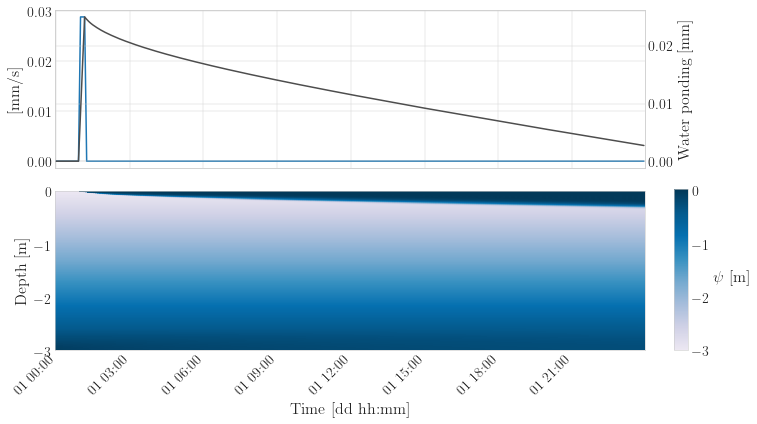

In [48]:
fig, ax = plt.subplots(2, 1, sharex='col', figsize=(10, 10/1.618)) 
norm = matplotlib.colors.Normalize(vmin=np.amin(ds.psi.values), vmax=np.amax(ds.psi.values))

ax[0].plot(ds.time.values, rain['0'][0:288]/300)
ax[0].set_ylabel('[mm/s]')

ax1=ax[0].twinx()
ds.waterVolume.sel(depth=0.0, method='nearest').plot(ax=ax1,color='0.3')
ax1.set_ylabel('Water ponding [mm]')
ax1.set_title(None)


a = ds.psi.plot(ax=ax[1], y='depth',add_colorbar=False, cmap=my_cmap, norm=norm)#, cbar_kwargs={'label': '$\psi$ [m]'})

ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Time [dd hh:mm]')


ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
ax[1].xaxis.set_tick_params(rotation=45)

cbar_ax = fig.add_axes([0.95, 0.19, 0.02, 0.36])
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('$\\psi$ [m]', rotation=0, labelpad=22)

plt.tight_layout()
plt.show()

abbiamo due fgrafici: 
- sopra abbiamo intensità di pioggia in azzurro in mm/s; nera: volume d'acqua che si accumula (ponding) in mm
quando inizia a piovere si accumula un certo V di acqua; parte si infiltra; durante evento di pioggia maggior parte si accumula

pioggia finisce: V acqua arriva al massimo poi decresce perchè si infiltra al suolo: una cosa che non si può riprodurre nei casi precedenti perchè non si sa a priori le c idrauliche che controllano gli scambi all'interfaccia atmosfera suolo.



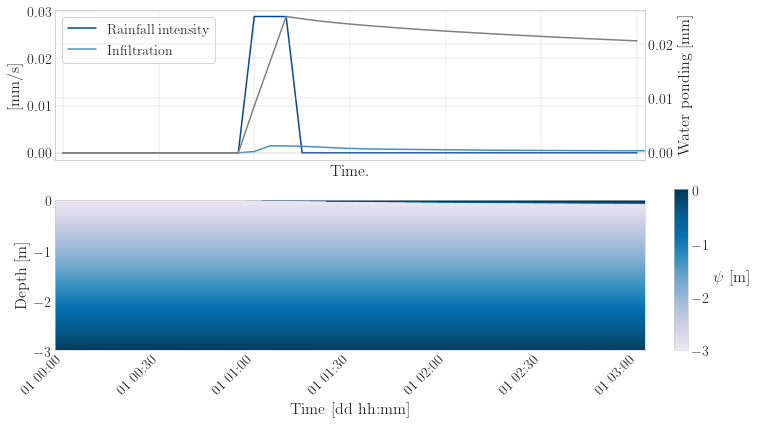

In [46]:
start = '2020-01-01 00:00'
end = '2020-01-01 03:00'

fig, ax = plt.subplots(2, 1, sharex='col', figsize=(10, 10/1.618)) 
norm = matplotlib.colors.Normalize(vmin=np.amin(ds.psi.values), vmax=np.amax(ds.psi.values))

ax[0].plot(ds.time.sel(time=slice(start,end)), rain['0'][start:end]/300,  color='#084594', label='Rainfall intensity')
(-ds.darcyVelocity.sel(dualDepth=0, method='nearest')*1000).plot(ax=ax[0], color='#4292c6', label='Infiltration')

ax[0].set_ylabel('[mm/s]')
ax[0].set_title(None)
ax[0].legend(loc='upper left')

ax1=ax[0].twinx()
ds.waterVolume.sel(time=slice(start,end)).sel(depth=0.0, method='nearest').plot(ax=ax1,color='0.5')
ax1.set_ylabel('Water ponding [mm]')
ax1.set_title(None)


a = ds.psi.sel(time=slice(start,end)).plot(ax=ax[1], y='depth',add_colorbar=False, cmap=my_cmap, norm=norm)#, cbar_kwargs={'label': '$\psi$ [m]'})

ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Time [dd hh:mm]')


ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
ax[1].xaxis.set_tick_params(rotation=45)

cbar_ax = fig.add_axes([0.95, 0.19, 0.02, 0.36])
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('$\\psi$ [m]', rotation=0, labelpad=22)

plt.tight_layout()
plt.show()

Dettaglio simulazione vista prima: in blu intensità di pioggia; in azzurro il flusso d'acqua all'interfaccia. come la pioggia inizia, l'infiltrazione è prossima a zero. di conseguenza per lo squilibrio tra precipita e entra abbiamo accumulo.
come la pioggia smette, V di acqua infiltra.


**se suolo asciutto**: la curva tende a zero molto velocemente; quello che ocnta sono i gradienti della suzione che sono molto grandi. a lezione ha mostrato un grafico dove ha messo a confrotto wet e dry: si vede che ci mette molto più a infiltrare ??. campo conducibilità idrauliche: suolo asciutto le c idrauliche sono molto piccole (blu più intenso); però gradienti suzione quello maggiore lo si ha dove c'è il fronte di infiltrazione, e la differenza dei due gradienti sono 2 ordini di grandezza quindi nel caso asciutto infiltrazione molto più rapida.

a parità degli altri imput, cambiando c iniziale fa si che riporta i risultati con delle differenze. nelle simulazioni che si fanno non si parte da suoli molto bagnati per vedere meglio le diversità



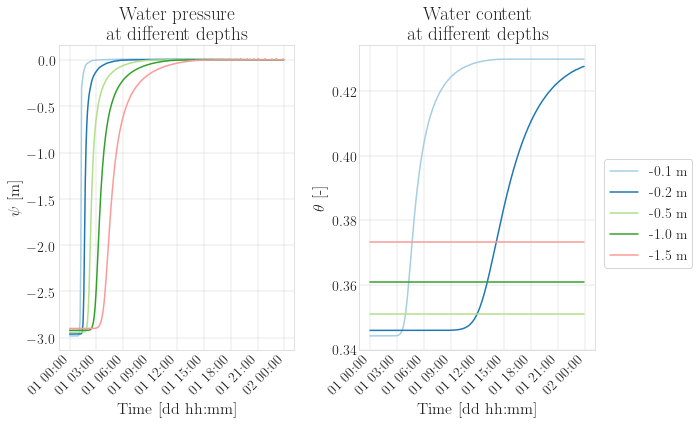

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10/1.618)) 

ds.psi.sel(depth=-0.1,  method='nearest').plot(ax=ax1, color=colors[0])
ds.psi.sel(depth=-0.2,  method='nearest').plot(ax=ax1, color=colors[1])
ds.psi.sel(depth=-0.5,  method='nearest').plot(ax=ax1, color=colors[2])
ds.psi.sel(depth=-1.0,  method='nearest').plot(ax=ax1, color=colors[3])
ds.psi.sel(depth=-1.5,  method='nearest').plot(ax=ax1, color=colors[4])


ax1.set_title('Water pressure \nat different depths')


ax1.set_ylabel('$\psi$ [m]')
ax1.set_xlabel('Time [dd hh:mm]')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
ax1.xaxis.set_tick_params(rotation=45)

ds.theta.sel(depth=-0.1, method='nearest').plot(ax=ax2, label = '-0.1 m', color=colors[0])
ds.theta.sel(depth=-0.2, method='nearest').plot(ax=ax2, label = '-0.2 m', color=colors[1])
ds.theta.sel(depth=-0.5, method='nearest').plot(ax=ax2, label = '-0.5 m', color=colors[2])
ds.theta.sel(depth=-1.0, method='nearest').plot(ax=ax2, label = '-1.0 m', color=colors[3])
ds.theta.sel(depth=-1.5, method='nearest').plot(ax=ax2, label = '-1.5 m', color=colors[4])

ax2.set_title('Water content \nat different depths')


ax2.set_ylabel('$\\theta$ [-]')
ax2.set_xlabel('Time [dd hh:mm]')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
ax2.xaxis.set_tick_params(rotation=45)

ax2.legend(bbox_to_anchor=(1.01,0.65), ncol=1)

plt.tight_layout()
plt.show()

abbiamo un unico layer: si vede solamente un ritardo tra i vari segnali ma non differiscono molto (no discontinuità)



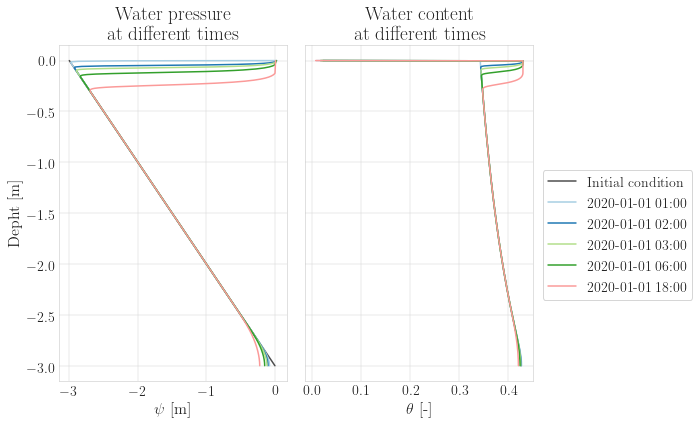

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row', figsize=(10, 10/1.618)) 

ds.psiIC.plot(ax=ax1, y='depth', label='Initial condition', color='0.3')
ds.psi.sel(time='2020-01-01 01:00').plot(ax=ax1, y='depth', label='2020-01-01 01:00', color=colors[0])
ds.psi.sel(time='2020-01-01 02:00').plot(ax=ax1, y='depth', label='2020-01-01 02:00', color=colors[1])
ds.psi.sel(time='2020-01-01 03:00').plot(ax=ax1, y='depth', label='2020-01-01 03:00', color=colors[2])
ds.psi.sel(time='2020-01-01 06:00').plot(ax=ax1, y='depth', label='2020-01-01 06:00', color=colors[3])
ds.psi.sel(time='2020-01-01 18:00').plot(ax=ax1, y='depth', label='2020-01-01 18:00', color=colors[4])
# ds.psi.sel(time='2020-01-02 00:00').plot(ax=ax1, y='depth', label='2020-01-02 00:00', color=colors[5])

ax1.set_title('Water pressure \nat different times')

ax1.set_ylabel('Depht [m]')
ax1.set_xlabel('$\psi$ [m]')

plt.plot(np.nan, np.nan, label='Initial condition', color='0.3')
ds.theta.sel(time='2020-01-01 01:00').plot(ax=ax2, y='depth', label='2020-01-01 01:00', color=colors[0])
ds.theta.sel(time='2020-01-01 02:00').plot(ax=ax2, y='depth', label='2020-01-01 02:00', color=colors[1])
ds.theta.sel(time='2020-01-01 03:00').plot(ax=ax2, y='depth', label='2020-01-01 03:00', color=colors[2])
ds.theta.sel(time='2020-01-01 06:00').plot(ax=ax2, y='depth', label='2020-01-01 06:00', color=colors[3])
ds.theta.sel(time='2020-01-01 18:00').plot(ax=ax2, y='depth', label='2020-01-01 18:00', color=colors[4])
# ds.theta.sel(time='2020-01-02 00:00').plot(ax=ax2, y='depth', label='2020-01-02 00:00', color=colors[5])

ax2.set_title('Water content \nat different times')

ax2.set_ylabel('')
ax2.set_xlabel('$\\theta$ [-]')


ax2.legend(bbox_to_anchor=(1.01,0.65), ncol=1)

plt.tight_layout()
plt.show()

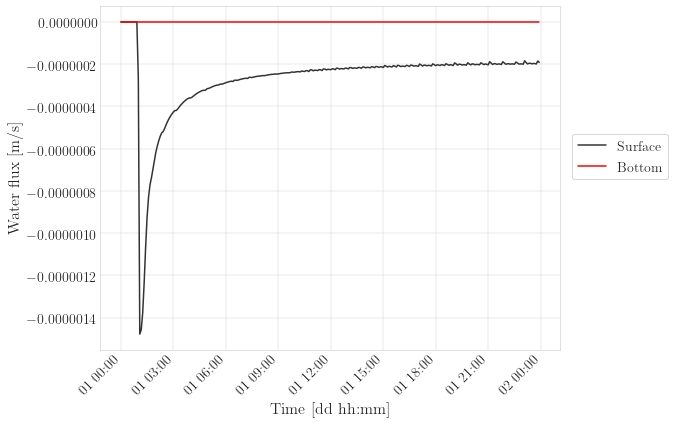

In [35]:
fig, ax= plt.subplots(1, 1, figsize=(10, 10/1.618)) 

ds.darcyVelocity.sel(dualDepth=0, method='nearest').plot(ax=ax, label='Surface', color='0.2')
ds.darcyVelocity.sel(dualDepth=-2, method='nearest').plot(ax=ax, label='Bottom', color='red')


ax.set_title('')

ax.set_ylabel('Water flux [m/s]')

ax.set_xlabel('Time [dd hh:mm]')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
ax.xaxis.set_tick_params(rotation=45)

ax.legend(bbox_to_anchor=(1.25,0.65), ncol=1)

plt.tight_layout()
plt.show()

Flussi: 
- al fondo: abbiamo messo un fondo impermeabile: FLUX == 0
- simulazione pari a zero anche in sup; poi aumenta; rimane più piccolo rispetto a intensità di pioggia
- flusso legato alla formazione di una lama d'acqua che si infiltra
- strati saturi del suolo: la v decresce = i gradienti diminuisce; la suzione in superficie diventa sempre più prossima aò vol di controllo quello sotto in sup --> flusso controllato dalla gravità.

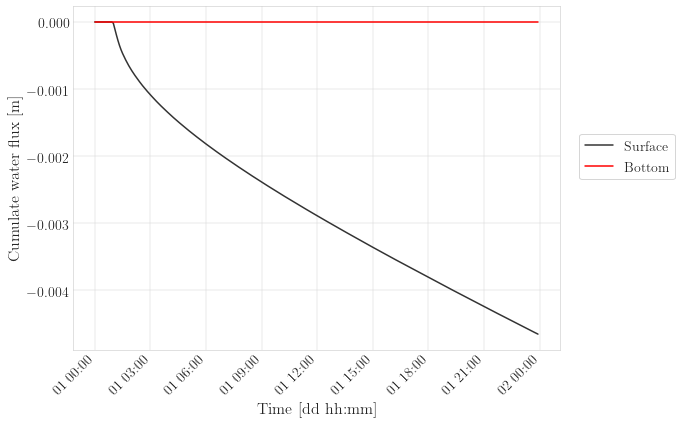

In [36]:
fig, ax= plt.subplots(1, 1, figsize=(10, 10/1.618)) 

(ds.darcyVelocity.sel(dualDepth=0, method='nearest')*60).cumsum().plot(ax=ax, label='Surface', color='0.2')
(ds.darcyVelocity.sel(dualDepth=-2, method='nearest')*60).cumsum().plot(ax=ax, label='Bottom', color='red')


ax.set_title('')

ax.set_ylabel('Cumulate water flux [m]')

ax.set_xlabel('Time [dd hh:mm]')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
ax.xaxis.set_tick_params(rotation=45)

ax.legend(bbox_to_anchor=(1.25,0.65), ncol=1)

plt.tight_layout()
plt.show()

dal fondo non esce nulla;
cumulata volumi infiltrati in superficie;

per ogni timestep si sa il volume entrato fino a quel momento